<a href="https://colab.research.google.com/github/satfail/AI-Reading-Materials/blob/master/Xception_carga_CheckPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargamos las imágenes el Drive e importamos Tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/CelulasRevGAN"

#raiz
PATH = "/content/drive/My Drive"

#ipunt

INPATH = PATH + '/CelulasRevGAN'



#checkpoints

CPATH = PATH + '/checkpointsCelulas'

entrenamiento  test


In [ ]:
# Reestablecer tf a la versión 2.4.1

!pip uninstall tensorflow -y
!pip install  tensorflow==2.4.1 


Uninstalling tensorflow-2.5.0:
  Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 394.3MB 39kB/s 
     |████████████████████████████████| 3.8MB 27.0MB/s 
     |████████████████████████████████| 2.9MB 27.7MB/s 
     |████████████████████████████████| 471kB 35.4MB/s 
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0


# Importamos las librerías generales para el desarrollo


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D

print(tf.__version__)

2.4.1


# Cargamos el set de Datos y Preprocesado
*   Defininmos el ImageDataGenerator para aumentar el dataset, con zoom, flip,rotación..
*  Hacemos plot para compronbar como quedan las imágenes generadas

In [ ]:
import pathlib
data_train = pathlib.Path(INPATH + '/entrenamiento/') 
count = len(list(data_train.glob('*/*.tiff'))) + len(list(data_train.glob('*/*.png')))
print('Entrenamiento : ' + str(count))

data_test = pathlib.Path(INPATH + '/test/') 
count = len(list(data_test.glob('*/*.tiff'))) + len(list(data_test.glob('*/*.png')))
print('Test : ' + str(count))
data_train

Entrenamiento : 4000
Test : 120


PosixPath('/content/drive/My Drive/CelulasRevGAN/entrenamiento')

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


batch_size = 32
img_height = 224
img_width = 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1) # set validation split

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='training',
    seed=77) # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_train, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='validation',
    seed=42) # set as validation data

test_generator = test_datagen.flow_from_directory(INPATH + '/test',
                                                target_size=(224, 224),
                                                batch_size=1,
                                                shuffle=False,
                                             class_mode='categorical')



Found 3600 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 400 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


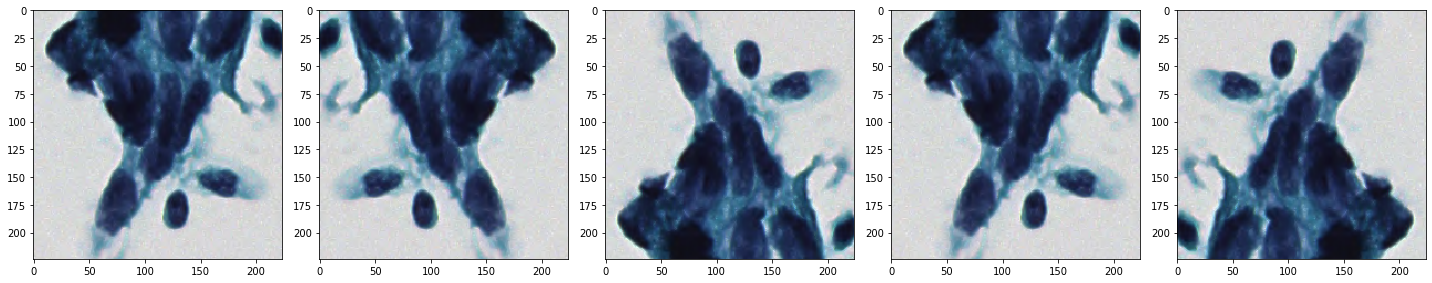

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator[1][0][0] for i in range(5)]
plotImages(augmented_images)

# Cargamos el modelo Xception

* Usamos los pesos de imagenet
* No incluimos la capa final, ya que debemos ajustarla a nuestro problema
* Damos la forma de entrada de nuestros datos

In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization
#from keras.applications.xception import Xception
from tensorflow.python.keras.applications.xception import Xception

baseModel = Xception(weights="imagenet", include_top=False,
	input_shape =  (224, 224, 3) )

83689472/83683744 [==============================] - 1s 0us/step


# Fine Tuning

* Ajustamos la cabeza de la red para que nos de una salida binaria acorde con nuestro problema

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
from tensorflow.python.keras.models import Model
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  137


# Fine Tuning

Congelamos las primeras 40 capas del modelo, para utilizar el mapa de caracteristicas general que ha cargado de los pesos.



In [ ]:
##Solo
for layer in model.layers[:40]:
    layer.trainable = False

for layer in model.layers[:]:
  print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# Calculamos los pasos por epoca y validación


In [ ]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

print(steps_per_epoch)
print(validation_steps)

112
12


# Cargamos el modelo del checkpoint


In [ ]:
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
optimizer = tf.keras.optimizers.Adam (lr=0.001)

checkpoint_filepath = CPATH + '/ultimoRev/'

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.load_weights(checkpoint_filepath)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    save_freq = 30,
    save_best_only=False)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)




# Opcional : Seguir con el entrenamiento

In [ ]:
history = model.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=1500,
          validation_data=validation_generator,
          validation_steps=validation_steps,
          callbacks=[reduce_lr,model_checkpoint_callback],verbose=1)

# Evaluamos el entrenamiento

---



In [ ]:
model.evaluate(x=validation_generator,
steps=validation_steps)

12/12 [==============================] - 277s 22s/step - loss: 1.3708 - accuracy: 0.8299


[1.1098366975784302, 0.8619791865348816]

# Predicción de resultados

In [ ]:
test_predict = model.predict(test_generator, steps = test_generator.n // 1, verbose =1)

120/120 [==============================] - 96s 792ms/step


In [ ]:
test_predict.shape

(120, 2)

In [ ]:
test_predict

array([[9.99999881e-01, 7.08266938e-08],
       [1.00000000e+00, 5.07375120e-08],
       [1.00000000e+00, 2.46806004e-12],
       [1.00000000e+00, 3.93749443e-11],
       [1.00000000e+00, 4.59633200e-12],
       [1.00000000e+00, 8.32078677e-12],
       [1.00000000e+00, 7.63745567e-10],
       [9.99996901e-01, 3.10182600e-06],
       [9.99993920e-01, 6.09912831e-06],
       [9.99262869e-01, 7.37151364e-04],
       [1.00000000e+00, 2.91459235e-09],
       [9.99998927e-01, 1.04733328e-06],
       [1.00000000e+00, 1.10000764e-09],
       [9.99999642e-01, 3.96286907e-07],
       [1.00000000e+00, 1.70219900e-16],
       [6.98842062e-03, 9.93011534e-01],
       [9.99999404e-01, 6.23952815e-07],
       [9.99951482e-01, 4.84862794e-05],
       [1.00000000e+00, 3.56791658e-12],
       [9.99999762e-01, 2.82459354e-07],
       [1.00000000e+00, 2.19868205e-13],
       [1.00000000e+00, 1.04875255e-08],
       [9.99981403e-01, 1.85861736e-05],
       [9.95397627e-01, 4.60235775e-03],
       [1.000000

In [ ]:
predict = []

for i in test_predict:
  predict.append(int(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
np.asarray(predict)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

# Métricas de exactitud, Matriz de Confusión y Curva ROC

In [ ]:
# Obtenemos la tasa de acierto del modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_generator.classes, np.asarray(predict))
accuracy

0.9666666666666667

In [ ]:
test_generator.class_indices

{'norevisables': 0, 'revisables': 1}

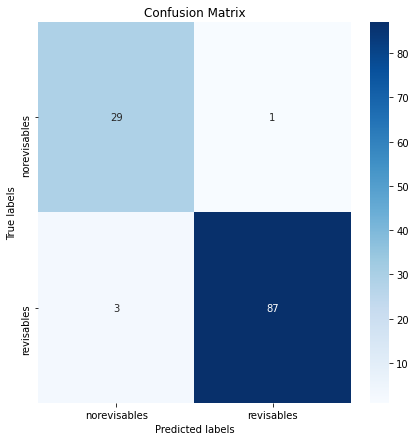

In [ ]:
# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_generator.classes, predict)
plt.figure(figsize = (7,7))
ax= plt.subplot()
sns.heatmap(cm, annot=True ,fmt="d",cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['norevisables', 'revisables']); ax.yaxis.set_ticklabels(['norevisables', 'revisables']);

In [ ]:
probs_positive = test_predict[:, 1]
probs_positive

array([7.0827099e-08, 5.0737512e-08, 2.4680507e-12, 3.9374570e-11,
       4.5963498e-12, 8.3208822e-12, 7.6374262e-10, 3.1018351e-06,
       6.0991747e-06, 7.3714898e-04, 2.9145979e-09, 1.0473292e-06,
       1.1000139e-09, 3.9628955e-07, 1.7022118e-16, 9.9301165e-01,
       6.2395640e-07, 4.8485999e-05, 3.5678756e-12, 2.8246015e-07,
       2.1987071e-13, 1.0487666e-08, 1.8586279e-05, 4.6023927e-03,
       1.1449928e-16, 4.6256350e-09, 2.9690010e-09, 1.0045519e-07,
       9.3739963e-08, 1.9319153e-03, 9.9999976e-01, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 9.9936503e-01,
       1.0000000e+00, 9.9987018e-01, 9.9993217e-01, 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 9.9999976e-01, 9.9990618e-01, 1.0000000e+00,
       9.9996912e-01, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e

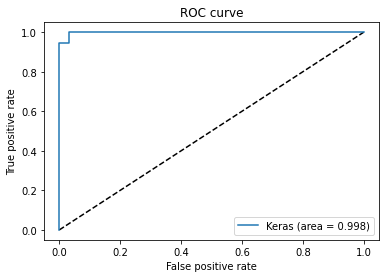

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr_keras, tpr_keras, thresholds_keras =  roc_curve ( test_generator.classes , probs_positive)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()